<a href="https://colab.research.google.com/github/kishan5111/Deep_Learning_Vault/blob/main/09_transfer_learning_in_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow - Fine-tuning
It's time to learn about a new kind of tranfer learning: fine-tuning.

In [1]:
# check if we're using GPU
!nvidia-smi

Thu Sep 14 05:54:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
We've created a bunch of helper function, let's import it.

It's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-14 05:54:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-14 05:54:57 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebooks
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google colab, when it times out colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem(recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of  food 101 dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-09-14 05:55:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   136MB/s    in 1.2s    

2023-09-14 05:55:02 (136 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [6]:
# check out how many images and subdirecotries are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
# create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# checkout class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# see an example of a batch of data
for images , labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.53000000e+02 2.55000000e+02 2.54000000e+02]
   [2.52571426e+02 2.55000000e+02 2.54000000e+02]
   ...
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.53000000e+02 2.55000000e+02 2.54000000e+02]
   [2.52571426e+02 2.55000000e+02 2.54000000e+02]
   ...
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.53000000e+02 2.55000000e+02 2.54000000e+02]
   [2.52663269e+02 2.55000000e+02 2.54000000e+02]
   ...
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]]

  ...

  [[2.53000000e+02 2.53000000e+02 2.53000000e+02]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models- https://www.tensorflow.org/guide/keras/functional

In [12]:
# 1. Create base model with tf.keras.applications
base_model= tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained aren't updated during training )
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using  a model like ResNet50V2 you will need to normalize inputs(you don't want for EfficientNetB0 it is built in )
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing the inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss= "categorical_crossentropy",
    optimizer= "adam",
    metrics=["accuracy"]
)

# 10. fit the model
history = model_0.fit(train_data_10_percent,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=(test_data),
                      validation_steps=(0.25 * len(test_data)),
                      epochs=5,
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                             experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing the inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230914-055511
Epoch 1/5
24/24 [==============================] - 21s 254ms/step - loss: 1.9582 - accuracy: 0.3853 - val_loss: 1.3782 - val_accuracy: 0.7297
Epoch 2/5
24/24 [==============================] - 5s 177ms/step - loss: 1.1462 - accuracy: 0.7427 - val_loss: 0.9048 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 5s 179ms/step - loss: 0.8149 - accuracy: 0.8160 - val_loss: 0.7111 - val_accuracy: 0.8359
Epoch 4/5
24/24 [==============================] - 5s 178ms/step - loss: 0.6555 - accuracy: 0.8533 - val_loss: 0.6421 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 176ms/step - loss: 0.5581 - accuracy: 0.8760 - val_loss: 0.5606 - val_accuracy: 0.8687


In [13]:
# evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5615 - accuracy: 0.8668


[0.5615288019180298, 0.8668000102043152]

In [14]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
# summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [16]:
# summary of our model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

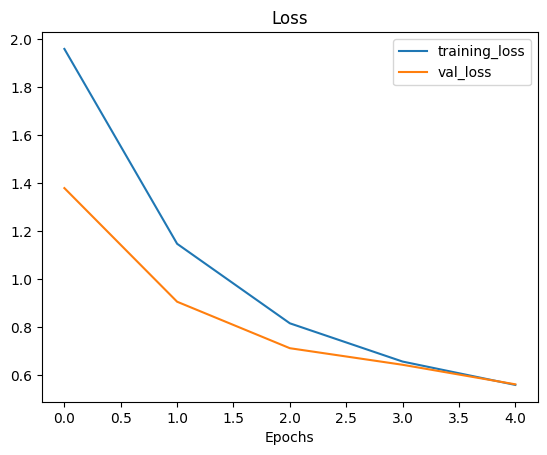

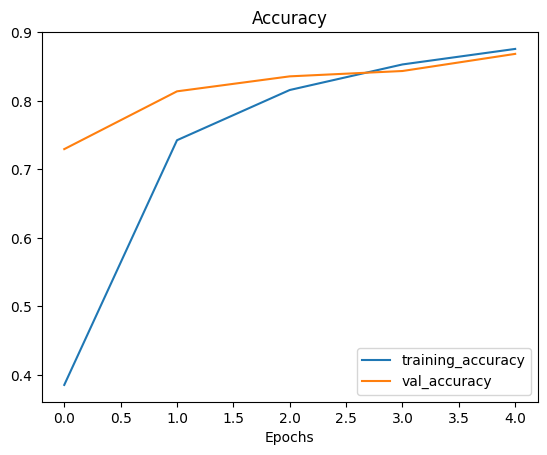

In [17]:
# check out training model's training
plot_loss_curves(history)

## Getting feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through 'base_model' of shape (None, 7, 7 , 1280).

But then when it passes through the GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3 and then pass it to GlobalAveragePooling2D)

In [18]:
# define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of Global Average Pooling 2Dtensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)
Shape of Global Average Pooling 2Dtensor:(1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

 Let's check out GlobalMaxPooling layer

In [20]:
# create a input tensor
input_shape= (1,4,4,3)

# set seed
tf.random.set_seed(42)
tensor = tf.random.normal(input_shape)

# Pass the tensor through the GlobalMAxPooling
global_maxpooling = tf.keras.layers.GlobalMaxPooling2D()(tensor)

# printing all outputs
print(f"Random input tensor:\n{tensor}\n")
print(f"GlobalMaxPooling tensor: \n{global_maxpooling}\n")
print(f"Random tensor shape: {tensor.shape}\n")
print((f"GlobalMaxPooling tensor shape:{global_maxpooling.shape}\n"))

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

GlobalMaxPooling tensor: 
[[0.9058464 1.1603122 1.6994323]]

Random tensor shape: (1, 4, 4, 3)

GlobalMaxPooling tensor shape:(1, 3)



In [21]:
# let's replicate GlobalMAxPooling
tf.reduce_max(tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

> **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happen is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case,  this is the output of the `tf.keras.layers.GlobalAveragePooling2D()`layer which can then be used to extract patterns out of our own specific problem.

### Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how about we set up a bunch of experiments to find out:

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2` - Use feature extraction transfer learning with 10% of the training with data augmentation

3. `model_3` - Use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4` - Use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [22]:
# Download and unzip data - preprocessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-09-14 05:56:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  33.9MB/s    in 3.8s    

2023-09-14 05:56:09 (33.9 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [24]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [25]:
# Setup data loaders
IMG_SIZE= (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) #default =32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits  of doing this within the TensorFlow Data Augmentation Documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

After reading the benefits of using data augmentation inside the model are:
* Preprocessing of images(augmenting them) happens on the GPU(much faster) rather than the CPU.
* Image data augmentation only happens during training , so we can still export our whole model and use it elsewhere.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, rooms , zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescale(1/255.) # keep for models like ResNEt50V2 but EfficientNet's Having rescaling builtin
   ],name="data_augmentation")



### Visualize our data augmentation layer (and see what happens to our data)

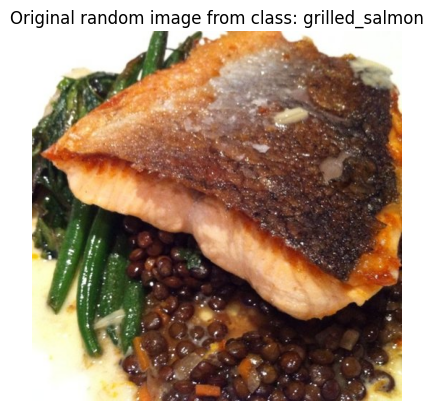

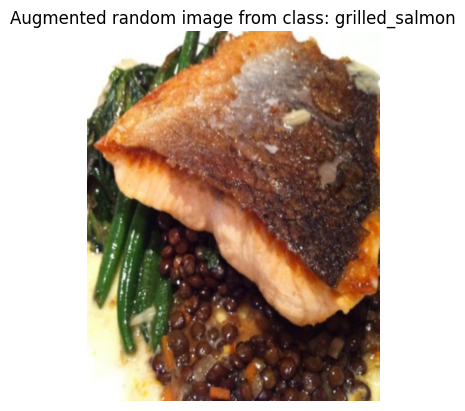

In [27]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now, let's plot our augmented random image
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model-1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs(after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output layer
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model using the inputs and ouputs
model_1 = keras.Model(inputs, outputs)


# Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# Fit the model
history_1_percent= model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_steps = int(0.25 * len(test_data)),
                              validation_data =test_data,
                              #track model training logs
                              callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230914-055848
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3196 - accuracy: 0.1286 - val_loss: 2.1289 - val_accuracy: 0.2664
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0847 - accuracy: 0.2857 - val_loss: 2.0087 - val_accuracy: 0.3931
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8945 - accuracy: 0.4571 - val_loss: 1.9060 - val_accuracy: 0.4507
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7645 - accuracy: 0.5286 - val_loss: 1.8359 - val_accuracy: 0.5016
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6114 - accuracy: 0.6571 - val_loss: 1.7354 - val_accuracy: 0.5312


In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [30]:
# Evaluate on the full test dataset
results_1_percent_data_aug =  model_1.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 1.7374 - accuracy: 0.5312


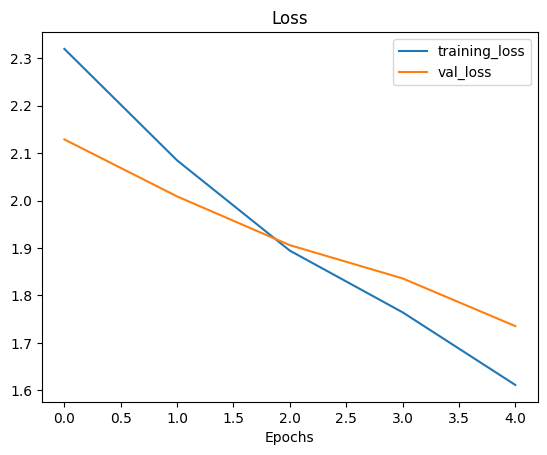

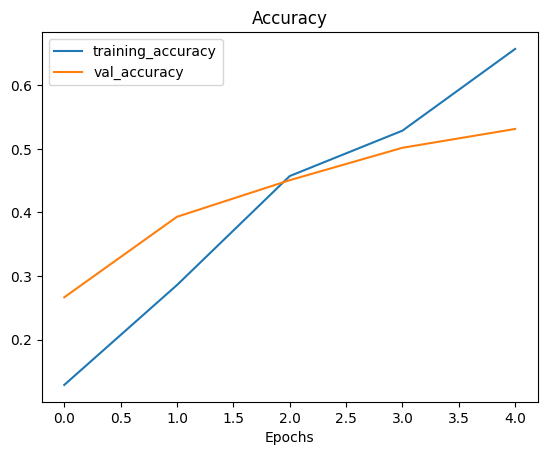

In [31]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model-2 :Feature extraction transfer learning with 10% data and data augmented layer

In [32]:
# Create model 2 with data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
], name="data_augmentation_layer")

In [33]:
import tensorflow as tf

# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create a input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs) #augment our training images(augmentation doenot occur in test_Data)

# Give a base model the inputs(after augmentation)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer as output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create a model
model_2 = keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off

In [34]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckPoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq='epoch',#save every epoch
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [35]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                             epochs=initial_epochs,
                             validation_data=test_data,
                             validation_steps=(0.25 * len(test_data)),
                             steps_per_epoch=len(train_data_10_percent),
                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                   experiment_name="10_percent_data__data_augmentation"),
                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data__data_augmentation/20230914-055933
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9449 - accuracy: 0.3627
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 694ms/step - loss: 1.9449 - accuracy: 0.3627 - val_loss: 1.3931 - val_accuracy: 0.6766
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.6867
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 475ms/step - loss: 1.3033 - accuracy: 0.6867 - val_loss: 0.9910 - val_accuracy: 0.7656
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9679 - accuracy: 0.7867
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 489ms/step - loss: 0.9679 - accuracy: 0.7867 - val_loss: 0.7949 - val_acc

In [36]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.5615 - accuracy: 0.8668


[0.5615289211273193, 0.8668000102043152]

In [37]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 66ms/step - loss: 0.6244 - accuracy: 0.8380


[0.6244176030158997, 0.8379999995231628]

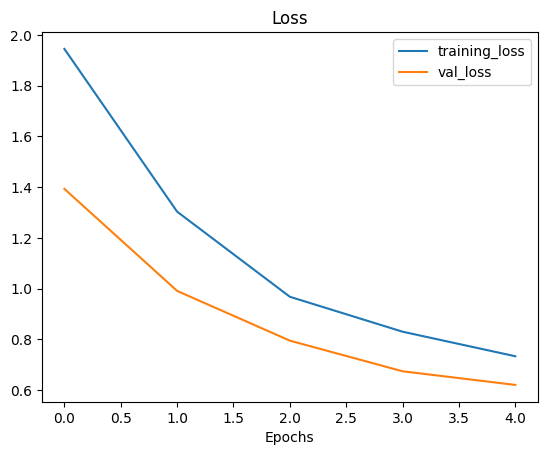

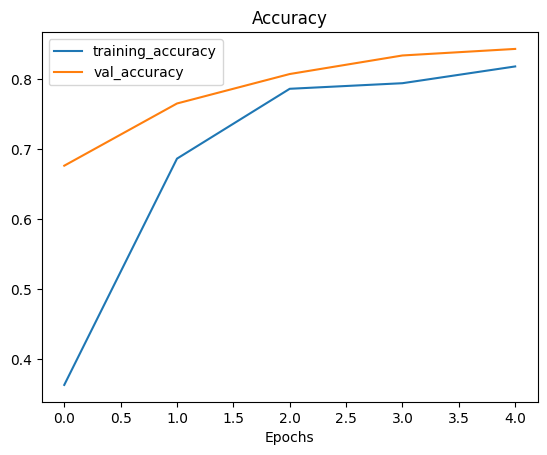

In [38]:
# plot model loss curves
plot_loss_curves(history_model_2)

### Loading in Checkpointed weights
Loading in checkpointed weights returns a model to specific checkpoint.


In [39]:
# Load in the saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [40]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results= model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.6244 - accuracy: 0.8380


In [41]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

True

In [42]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [43]:
# Check the difference between two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model-3 Fine-tuning the existing model on 10% of the data
> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [44]:
# Layers in the loaded model
model_2.layers

In [45]:
# Are these layers trainanle?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b1de910ff10> True
<keras.src.engine.sequential.Sequential object at 0x7b1de910cd90> True
<keras.src.engine.functional.Functional object at 0x7b1decdb3850> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7b1dfc0aae90> True
<keras.src.layers.core.dense.Dense object at 0x7b1de90dd600> True


In [46]:
# what layer are in base model(EfficientNetB0) and are they trainable?
for i,layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [47]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# To begin finr-tuning, let's start by setting last 10layers of base_model.trainable = True
base_model.trainable= True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable= False

# Recompile (we have to recompilte our models every time we make a change)
model_2.compile(
loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),#when fine-tuning we typically want to lower the learning rate by 10x
metrics=["accuracy"])

> **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x(though different sources will claim other values).
A good resource for information on this is the ULMFIT paper: https://arxiv.org/abs/1801.06146

In [49]:
# Check which layer are tunable(trainable)
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [50]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variable are there?
print(len(model_2.trainable_variables))

12


In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs= initial_epochs +5

# Refit the model(same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs= fine_tune_epochs,
                                              validation_data=test_data,
                                              validation_steps=(0.25 * len(test_data)),
                                              initial_epoch=history_model_2.epoch[-1], #start training from previous training where we left off
                                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230914-060506
Epoch 5/10
24/24 [==============================] - 23s 587ms/step - loss: 0.6266 - accuracy: 0.8240 - val_loss: 0.5181 - val_accuracy: 0.8406
Epoch 6/10
24/24 [==============================] - 10s 405ms/step - loss: 0.5027 - accuracy: 0.8587 - val_loss: 0.4769 - val_accuracy: 0.8578
Epoch 7/10
24/24 [==============================] - 11s 440ms/step - loss: 0.4631 - accuracy: 0.8600 - val_loss: 0.4607 - val_accuracy: 0.8578
Epoch 8/10
24/24 [==============================] - 11s 440ms/step - loss: 0.4199 - accuracy: 0.8667 - val_loss: 0.4564 - val_accuracy: 0.8703
Epoch 9/10
24/24 [==============================] - 10s 411ms/step - loss: 0.3567 - accuracy: 0.8907 - val_loss: 0.4598 - val_accuracy: 0.8578
Epoch 10/10
24/24 [==============================] - 9s 346ms/step - loss: 0.3203 - accuracy: 0.9080 - val_loss: 0.4626 - val_accuracy: 0.8531


In [52]:
# Evaluate the fine_tuned model(model_3 which is actually model_2 fine_tuned for another 5 epochs)
results_fine_tune_10_percent =model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4229 - accuracy: 0.8600


In [53]:
results_10_percent_data_aug

[0.6244176030158997, 0.8379999995231628]

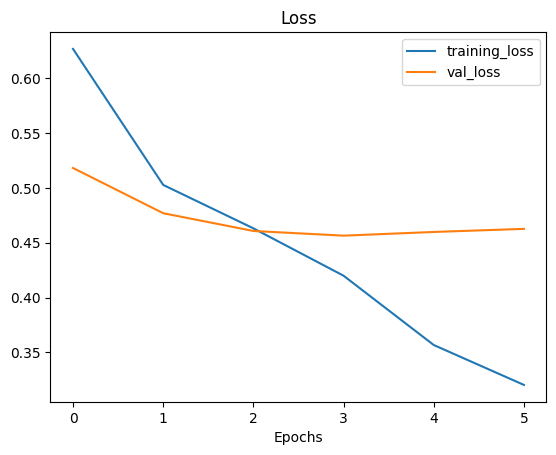

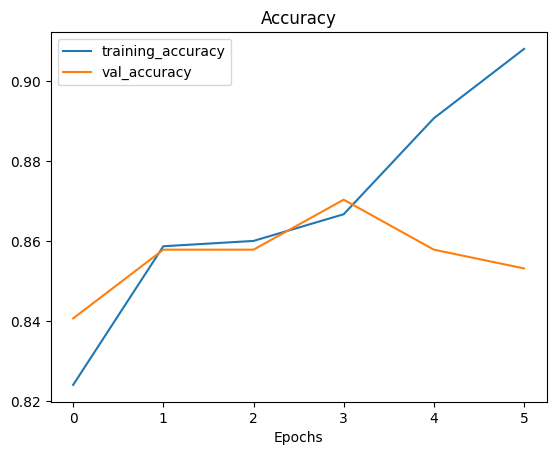

In [54]:
# check out the loss curve of our fine_tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another(e.g. before and after fine-tuning).

In [55]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    #Combine orginal history metrics with new history metrics
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss= val_loss + new_history.history["val_loss"]

    #Make plot for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label ="Training Accuraacy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation accuracy")

    # make plot for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label ="Training loss")
    plt.plot(total_val_loss, label="Validation loss")
    plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation loss")

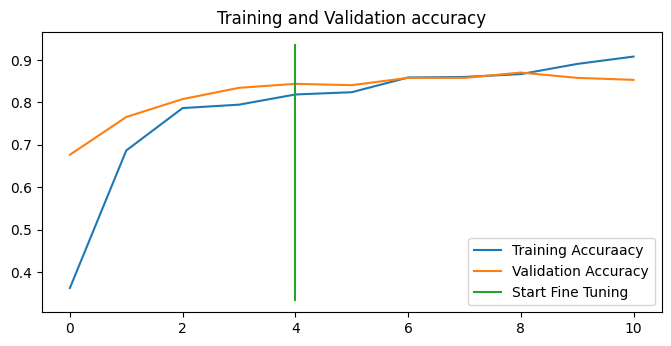

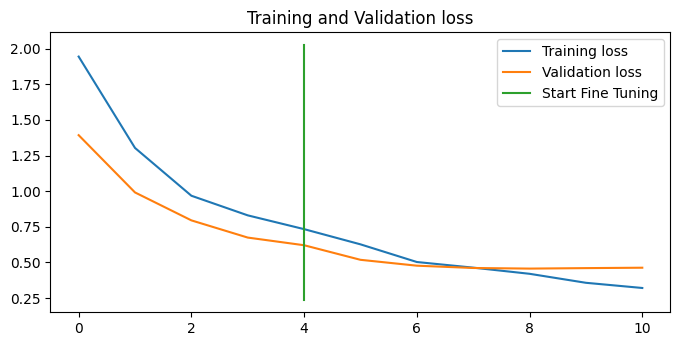

In [56]:
compare_histories(history_model_2,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model-4: Fine-tuning and existing model on all the training data

In [57]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-09-14 06:06:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  85.1MB/s    in 7.0s    

2023-09-14 06:06:36 (70.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [58]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [59]:
# How many images are we picking up with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [60]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test datasets).

Let's verify this...

In [61]:
# Evaluate model 2(this is fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4229 - accuracy: 0.8600


[0.422850638628006, 0.8600000143051147]

In [62]:
results_fine_tune_10_percent

[0.42285069823265076, 0.8600000143051147]

To train a fine-tuning model (model_4) we need to revert model_2 back to it's feature extraction model.

In [63]:
#Load weights from checkpoint, that way we can fine_tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [64]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6244 - accuracy: 0.8380


[0.6244173645973206, 0.8379999995231628]

In [65]:
# check to see it our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6244176030158997, 0.8379999995231628]

Alright, the previous steps might seem confusing but all we've done is:
 1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
 2. Fine-tuned the same model on the same model on the same 10% of data for a further 5 epochs with the top 10 layers of the base model unfrozen(model_3).
 3. Saved the results and training logs each time.
 4. Reloaded the model from step 1 to do same as step 2 except this time we are going to use all of the data(model_4).

In [66]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [67]:
# Let's drill into our base_model(EfficeientNetB0) and see what layers are trainable
for i , layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [68]:
# Recompile
model_2.compile(
    loss= "categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [69]:
# fit the model on all data and fine tune
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=(0.25 * len(test_data)),
                                           initial_epoch=history_model_2.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name="full_10_classes")])

Saving TensorBoard log files to: transfer_learning/full_10_classes/20230914-060933
Epoch 5/10
235/235 [==============================] - 73s 281ms/step - loss: 0.6557 - accuracy: 0.7871 - val_loss: 0.3777 - val_accuracy: 0.8828
Epoch 6/10
235/235 [==============================] - 59s 248ms/step - loss: 0.5295 - accuracy: 0.8283 - val_loss: 0.3608 - val_accuracy: 0.8922
Epoch 7/10
235/235 [==============================] - 53s 222ms/step - loss: 0.4626 - accuracy: 0.8493 - val_loss: 0.3335 - val_accuracy: 0.8875
Epoch 8/10
235/235 [==============================] - 51s 216ms/step - loss: 0.4235 - accuracy: 0.8604 - val_loss: 0.2906 - val_accuracy: 0.9031
Epoch 9/10
235/235 [==============================] - 45s 191ms/step - loss: 0.3869 - accuracy: 0.8745 - val_loss: 0.2574 - val_accuracy: 0.9203
Epoch 10/10
235/235 [==============================] - 45s 191ms/step - loss: 0.3633 - accuracy: 0.8836 - val_loss: 0.2801 - val_accuracy: 0.9141


In [70]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 67ms/step - loss: 0.2745 - accuracy: 0.9096


[0.27451056241989136, 0.909600019454956]

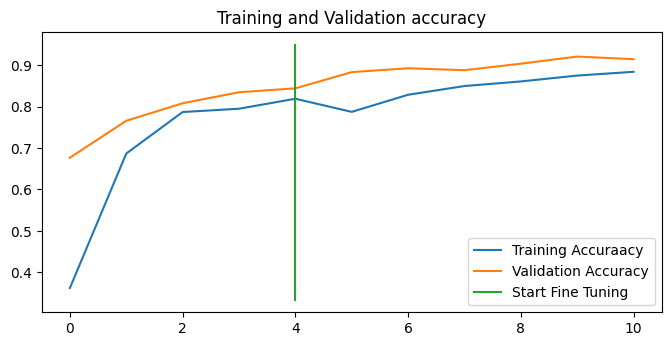

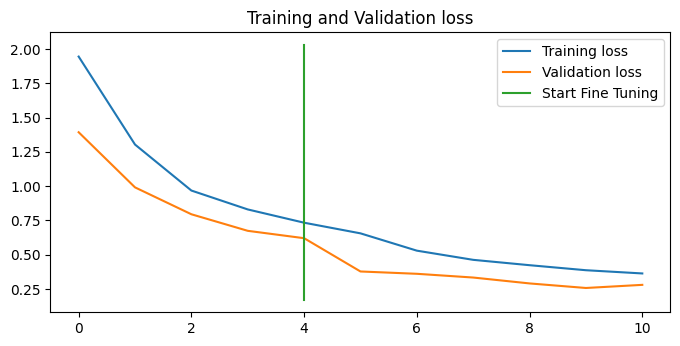

In [71]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_model_2,
                 new_history=history_fine_10_classes_full)

## View experiments in TensorBoard

In [ ]:
# View tensorboard logs of transfer modelling experiments (should-4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes"\
    --description "A series of different transfer learning experiments with varrying amounts of Food101 data "\
    --one_shot #exits the uploader once its finished uploading

 View your TensorBoard at https://tensorboard.dev/experiment/PWKBCe6bT3Oa4skyu4wZTQ/

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/PWKBCe6bT3Oa4skyu4wZTQ/  
	  
      Name                 Transfer Learning Experiments with 10 Food101 Classes      
	  Description          A series of different transfer learning experiments with varrying amounts of Food101 data   
	  Created              2023-07-10 10:11:12 (7 minutes ago)
	  Updated              2023-07-10 10:11:17 (7 minutes ago)
	  Runs                 10
  	Tags                 5
	  Scalars              162
	  Tensor bytes         0
	  Binary object bytes  4584001
https://tensorboard.dev/experiment/wsPfqO47RqKwYev1rvzDvg/
    
     Name                 EfficentNetB0 vs ResNet50V2
     Description          Comparing two different TF Hub feature extraction model using 10% of training data
     Created              2023-07-06 06:08:19
     Updated              2023-07-06 06:08:22
     Runs                 4
     Tags                 5
     Scalars              60
     Tensor bytes         0
     Binary object bytes  3155697
Total: 2 experiment(s)

In [ ]:
#  To delete an experiment
# !tensorboard dev delete --experiment_id ...